In [1]:
# !pip install kaggle
# from google.colab import files
# files.upload()

In [2]:
# !ls -1ha kaggle.json

In [3]:
from google.colab import drive

drive.mount('/content/drive/')

Mounted at /content/drive/


In [4]:
# !mkdir -p ~/.kaggle
# !cp kaggle.json ~/.kaggle/
# # Permission Warning 이 일어나지 않도록 
# !chmod 600 ~/.kaggle/kaggle.json
# # 본인이 참가한 모든 대회 보기 
# !kaggle competitions list

In [5]:
!pip3 install tokenizers wandb sentencepiece

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 6.6 MB 14.6 MB/s 
     |████████████████████████████████| 1.8 MB 69.4 MB/s 
     |████████████████████████████████| 1.2 MB 74.4 MB/s 
     |████████████████████████████████| 181 kB 95.1 MB/s 
     |████████████████████████████████| 145 kB 84.6 MB/s 
     |████████████████████████████████| 63 kB 2.0 MB/s 
  Created wheel for pathtools: filename=pathtools-0.1.2-py3-none-any.whl size=8806 sha256=dd34d8d224d72b45c8521647e983043af57965da8fbc08a3ab6b2ec57757bfb5
  Stored in directory: /root/.cache/pip/wheels/3e/31/09/fa59cef12cdcfecc627b3d24273699f390e71828921b2cbba2
Successfully built pathtools


In [6]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 4.2 MB 15.8 MB/s 
     |████████████████████████████████| 596 kB 81.0 MB/s 
     |████████████████████████████████| 86 kB 5.9 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [7]:
import os
os.chdir("drive/") 
os.chdir('My Drive')
os.chdir('Kaggle')

In [8]:
# !kaggle competitions download -c us-patent-phrase-to-phrase-matching
# !unzip us-patent-phrase-to-phrase-matching.zip
# !ls

# !git clone https://github.com/microsoft/COCO-LM.git
# !pip3 install -r requirements.txt

In [9]:
# debert_v3_tokenizer_path = 'deberta-v2-v3-fast-tokenizer'
# %env TOKENIZERS_PARALLELISM=true

# import shutil
# from pathlib import Path

# transformers_path = Path('/usr/local/lib/python3.7/dist-packages/transformers')
# input_dir = Path('./deberta-v2-v3-fast-tokenizer')

# convert_file = input_dir / "convert_slow_tokenizer.py"
# conversion_path = transformers_path / convert_file.name

# if conversion_path.exists():
#     conversion_path.unlink()

# shutil.copy(convert_file, transformers_path)
# deberta_v2_path = transformers_path / "models" / "deberta_v2"

# for filename in ['tokenization_deberta_v2.py', 'tokenization_deberta_v2_fast.py']:
#     filepath = deberta_v2_path/filename
    
#     if filepath.exists():
#         filepath.unlink()
#     shutil.copy(input_dir/filename, filepath)

In [10]:
OUTPUT_DIR = './pppm-mse-3/'
if not os.path.exists(OUTPUT_DIR):
    os.makedirs(OUTPUT_DIR)

In [11]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Sun Jun  5 15:35:08 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   39C    P0    24W / 300W |      0MiB / 16160MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [12]:
# ====================================================
# CFG
# ====================================================
class CFG:
    wandb=True
    competition='PPPM'
    _wandb_kernel='bluehills'
    debug=False
    apex=True
    print_freq=100
    num_workers=4
    model="microsoft/cocolm-large"
    scheduler='linear' # ['linear', 'cosine']
    batch_scheduler=True
    num_cycles=0.5
    num_warmup_steps=50 # [0, 50, 100]
    epochs=4
    encoder_lr=2e-5
    decoder_lr=2e-5
    min_lr=5e-7
    eps=5e-7
    betas=(0.9, 0.999)
    batch_size=14
    fc_dropout=0.15
    target_size=1
    max_len=512
    weight_decay=0.01
    gradient_accumulation_steps=1
    max_grad_norm=1000
    seed=42
    train_all_index=20
    n_fold=5
    trn_fold=[0, 1, 2, 3, 4]
    train=True
    
if CFG.debug:
    CFG.epochs = 2
    CFG.trn_fold = [0]

In [13]:
# ====================================================
# wandb
# ====================================================
if CFG.wandb:
    import wandb
    try:
        # from kaggle_secrets import UserSecretsClient
        # user_secrets = UserSecretsClient()
        # secret_value_0 = user_secrets.get_secret("wandb_api")
        # wandb.login(key=secret_value_0)
        print('login to wandb')
        wandb.login()
        anony = None
    except:
        anony = "must"
        print('If you want to use your W&B account, go to Add-ons -> Secrets and provide your W&B access token. Use the Label name as wandb_api. \nGet your W&B access token from here: https://wandb.ai/authorize')


    def class2dict(f):
        return dict((name, getattr(f, name)) for name in dir(f) if not name.startswith('__'))

    run = wandb.init(project='PPPM-MSE-3', 
                     name=CFG.model,
                     config=class2dict(CFG),
                     group=CFG.model,
                     job_type="train",
                     anonymous=anony)

login to wandb


<IPython.core.display.Javascript object>

wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: bluehills. Use `wandb login --relogin` to force relogin


# Library

In [14]:
# !pip3 install cocolm

In [15]:
# ====================================================
# Library
# ====================================================
import os
import gc
import re
import ast
import sys
import copy
import json
import time
import math
import shutil
import string
import pickle
import random
import joblib
import itertools
from pathlib import Path
import warnings
warnings.filterwarnings("ignore")

import scipy as sp
import numpy as np
import pandas as pd
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
from tqdm.auto import tqdm
from sklearn.metrics import f1_score
from sklearn.model_selection import StratifiedKFold, GroupKFold, KFold
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedGroupKFold

import torch
print(f"torch.__version__: {torch.__version__}")
import torch.nn as nn
from torch.nn import Parameter
import torch.nn.functional as F
from torch.optim import Adam, SGD, AdamW
from torch.utils.data import DataLoader, Dataset
import torch.cuda.amp as amp

import tokenizers
import transformers
print(f"tokenizers.__version__: {tokenizers.__version__}")
print(f"transformers.__version__: {transformers.__version__}")
from transformers import AutoTokenizer, AutoModel, AutoConfig, AutoModelForSequenceClassification
from transformers import get_linear_schedule_with_warmup, get_cosine_schedule_with_warmup
from transformers import AutoTokenizer, AutoConfig, AutoModelForTokenClassification



%env TOKENIZERS_PARALLELISM=true

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

torch.__version__: 1.11.0+cu113
tokenizers.__version__: 0.12.1
transformers.__version__: 4.19.2
env: TOKENIZERS_PARALLELISM=true


In [16]:
os.chdir('COCO-LM/huggingface')
from cocolm.modeling_cocolm import COCOLMModel
from cocolm.configuration_cocolm import COCOLMConfig
from cocolm.tokenization_cocolm import COCOLMTokenizer
os.chdir('../..')

Better speed can be achieved with apex installed from https://www.github.com/nvidia/apex.


# Utils

In [17]:
# ====================================================
# Utils
# ====================================================
def get_score(y_true, y_pred):
    score = sp.stats.pearsonr(y_true, y_pred)[0]
    return score


def get_logger(filename=OUTPUT_DIR+'train'):
    from logging import getLogger, INFO, StreamHandler, FileHandler, Formatter
    logger = getLogger(__name__)
    logger.setLevel(INFO)
    handler1 = StreamHandler()
    handler1.setFormatter(Formatter("%(message)s"))
    handler2 = FileHandler(filename=f"{filename}.log")
    handler2.setFormatter(Formatter("%(message)s"))
    logger.addHandler(handler1)
    logger.addHandler(handler2)
    return logger

LOGGER = get_logger()

def seed_everything(seed=42):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    
seed_everything(seed=42)

# Tokenizer

In [18]:
# ====================================================
# tokenizer
# ====================================================
# tokenizer = AutoTokenizer.from_pretrained(CFG.model)
tokenizer = COCOLMTokenizer.from_pretrained(CFG.model)
# tokenizer.save_pretrained(OUTPUT_DIR+'tokenizer/')
CFG.tokenizer = tokenizer

Downloading:   0%|          | 0.00/1.30M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/719k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/472 [00:00<?, ?B/s]

# Data Loading

In [19]:
# ====================================================
# Data Loading
# ====================================================
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
submission = pd.read_csv('sample_submission.csv')
print(f"train.shape: {train.shape}")
print(f"test.shape: {test.shape}")
print(f"submission.shape: {submission.shape}")
display(train.head())
display(test.head())
display(submission.head())

train.shape: (36473, 5)
test.shape: (36, 4)
submission.shape: (36, 2)


,id,anchor,target,context,score
0,37d61fd2272659b1,abatement,abatement of pollution,A47,0.50
1,7b9652b17b68b7a4,abatement,act of abating,A47,0.75
2,36d72442aefd8232,abatement,active catalyst,A47,0.25
3,5296b0c19e1ce60e,abatement,eliminating process,A47,0.50
4,54c1e3b9184cb5b6,abatement,forest region,A47,0.00


,id,anchor,target,context
0,4112d61851461f60,opc drum,inorganic photoconductor drum,G02
1,09e418c93a776564,adjust gas flow,altering gas flow,F23
2,36baf228038e314b,lower trunnion,lower locating,B60
3,1f37ead645e7f0c8,cap component,upper portion,D06
4,71a5b6ad068d531f,neural stimulation,artificial neural network,H04


,id,score
0,4112d61851461f60,0
1,09e418c93a776564,0
2,36baf228038e314b,0
3,1f37ead645e7f0c8,0
4,71a5b6ad068d531f,0


In [20]:
# ====================================================
# CPC Data
# ====================================================
def get_cpc_texts():
    contexts = []
    pattern = '[A-Z]\d+'
    for file_name in os.listdir('./CPCSchemeXML202105'):
        result = re.findall(pattern, file_name)
        if result:
            contexts.append(result)
    contexts = sorted(set(sum(contexts, [])))
    results = {}
    for cpc in ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'Y']:
        with open(f'./CPCTitleList202202/cpc-section-{cpc}_20220201.txt') as f:
            s = f.read()
        pattern = f'{cpc}\t\t.+'
        result = re.findall(pattern, s)
        cpc_result = result[0].lstrip(pattern)
        for context in [c for c in contexts if c[0] == cpc]:
            pattern = f'{context}\t\t.+'
            result = re.findall(pattern, s)
            results[context] = cpc_result + ". " + result[0].lstrip(pattern)
    return results


def get_cpc_texts_nakama():
    contexts = []
    pattern = '[A-Z]\d+'
    for file_name in os.listdir('./CPCSchemeXML202105'):
        result = re.findall(pattern, file_name)
        if result:
            contexts.append(result)
    contexts = sorted(set(sum(contexts, [])))
    results = {}
    for cpc in ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'Y']:
        with open(f'./CPCTitleList202202/cpc-section-{cpc}_20220201.txt') as f:
            s = f.read()
        pattern = f'{cpc}\t\t.+'
        result = re.findall(pattern, s)
        cpc_result = result[0].lstrip(pattern)
        for context in [c for c in contexts if c[0] == cpc]:
            pattern = f'{context}\t\t.+'
            result = re.findall(pattern, s)
            results[context] = cpc_result + ". " + result[0].lstrip(pattern)
    return results


cpc_texts = get_cpc_texts()
# cpc_texts = get_cpc_texts_nakama()
torch.save(cpc_texts, OUTPUT_DIR+"cpc_texts.pth")
train['context_text'] = train['context'].map(cpc_texts)
test['context_text'] = test['context'].map(cpc_texts)
display(train.head())
display(test.head())

,id,anchor,target,context,score,context_text
0,37d61fd2272659b1,abatement,abatement of pollution,A47,0.50,HUMAN NECESSITIES. FURNITURE; DOMESTIC ARTICLE...
1,7b9652b17b68b7a4,abatement,act of abating,A47,0.75,HUMAN NECESSITIES. FURNITURE; DOMESTIC ARTICLE...
2,36d72442aefd8232,abatement,active catalyst,A47,0.25,HUMAN NECESSITIES. FURNITURE; DOMESTIC ARTICLE...
3,5296b0c19e1ce60e,abatement,eliminating process,A47,0.50,HUMAN NECESSITIES. FURNITURE; DOMESTIC ARTICLE...
4,54c1e3b9184cb5b6,abatement,forest region,A47,0.00,HUMAN NECESSITIES. FURNITURE; DOMESTIC ARTICLE...


,id,anchor,target,context,context_text
0,4112d61851461f60,opc drum,inorganic photoconductor drum,G02,PHYSICS. OPTICS
1,09e418c93a776564,adjust gas flow,altering gas flow,F23,MECHANICAL ENGINEERING; LIGHTING; HEATING; WEA...
2,36baf228038e314b,lower trunnion,lower locating,B60,PERFORMING OPERATIONS; TRANSPORTING. VEHICLES ...
3,1f37ead645e7f0c8,cap component,upper portion,D06,TEXTILES; PAPER. TREATMENT OF TEXTILES OR THE ...
4,71a5b6ad068d531f,neural stimulation,artificial neural network,H04,ELECTRICITY. ELECTRIC COMMUNICATION TECHNIQUE


In [21]:
# train['text'] = tokenizer.cls_token + train['anchor'] + tokenizer.sep_token + train['target'] + tokenizer.sep_token  + train['context_text']
# test['text'] = tokenizer.cls_token + test['anchor'] + tokenizer.sep_token + test['target'] + tokenizer.sep_token  + test['context_text']
# display(train.head())
# display(test.head())

# EDA

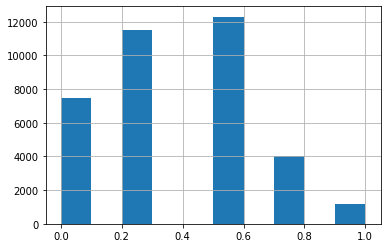

In [22]:
train['score'].hist()

In [23]:
display(train['context'].apply(lambda x: x[0]).value_counts())

B    8019
H    6195
G    6013
C    5288
A    4094
F    4054
E    1531
D    1279
Name: context, dtype: int64

# CV Split

In [24]:
# ====================================================
# CV split
# ====================================================
# train['score_map'] = train['score'].map({0.00: 0, 0.25: 1, 0.50: 2, 0.75: 3, 1.00: 4})
# Fold = StratifiedKFold(n_splits=CFG.n_fold, shuffle=True, random_state=CFG.seed)
# for n, (train_index, val_index) in enumerate(Fold.split(train, train['score_map'])):
#     train.loc[val_index, 'fold'] = int(n)
# train['fold'] = train['fold'].astype(int)
# display(train.groupby('fold').size())

In [25]:
# train['score_map'] = train['score'].map({0.00: 0, 0.25: 1, 0.50: 2, 0.75: 3, 1.00: 4})

# encoder = LabelEncoder()
# train['anchor_map'] = encoder.fit_transform(train['anchor'])

# kf = StratifiedGroupKFold(n_splits=CFG.n_fold, shuffle=True, random_state=CFG.seed)
# for n, (_, valid_index) in enumerate(kf.split(train, train['score_map'], groups=train['anchor_map'])):
#     train.loc[valid_index, 'fold'] = int(n)

# train['fold'] = train['fold'].astype(int)

In [26]:
# titles = pd.read_csv('./titles.csv')
# train = train.merge(titles, left_on='context', right_on='code')
# train['fold'] = -1
# kf = StratifiedGroupKFold(n_splits=CFG.n_fold, shuffle=True, random_state=CFG.seed)

# for f, (t_, v_) in enumerate(kf.split(X=train, y=train['anchor'], groups=train['anchor'])):
#     train.loc[v_, 'fold'] = f

# train['fold'].hist()
# train['text'] = train['anchor'] + '[SEP]' + train['title'].apply(str.lower)
# train = train[['id','anchor', 'target', 'context', 'score', 'title', 'fold', 'text']]

In [27]:
!pip3 install -q iterative-stratification
from iterstrat.ml_stratifiers import MultilabelStratifiedKFold

dfx = pd.get_dummies(train, columns=["score"]).groupby(["anchor"], as_index=False).sum()
cols = [c for c in dfx.columns if c.startswith("score_") or c == "anchor"]
dfx = dfx[cols]

mskf = MultilabelStratifiedKFold(n_splits=CFG.n_fold, shuffle=True, random_state=42)
labels = [c for c in dfx.columns if c != "anchor"]
dfx_labels = dfx[labels]
dfx["fold"] = -1

for fold, (trn_, val_) in enumerate(mskf.split(dfx, dfx_labels)):
    print(len(trn_), len(val_))
    dfx.loc[val_, "fold"] = fold

train = train.merge(dfx[["anchor", "fold"]], on="anchor", how="left")
print(train.fold.value_counts())

587 146
587 146
586 147
586 147
586 147
2    7683
0    7592
3    7324
1    6995
4    6879
Name: fold, dtype: int64


In [28]:
if CFG.debug:
    display(train.groupby('fold').size())
    train = train.sample(n=1000, random_state=0).reset_index(drop=True)
    display(train.groupby('fold').size())

# Dataset

In [29]:
# ====================================================
# Define max_len
# ====================================================
lengths_dict = {}

lengths = []
tk0 = tqdm(cpc_texts.values(), total=len(cpc_texts))
for text in tk0:
    length = len(tokenizer.encode(text, add_special_tokens=False))
    lengths.append(length)
lengths_dict['context_text'] = lengths

for text_col in ['anchor', 'target']:
    lengths = []
    tk0 = tqdm(train[text_col].fillna("").values, total=len(train))
    for text in tk0:
        length = len(tokenizer.encode(text, add_special_tokens=False))
        lengths.append(length)
    lengths_dict[text_col] = lengths
    
CFG.max_len = max(lengths_dict['anchor']) + max(lengths_dict['target'])\
                + max(lengths_dict['context_text']) + 4 # CLS + SEP + SEP + SEP
LOGGER.info(f"max_len: {CFG.max_len}")

  0%|          | 0/136 [00:00<?, ?it/s]

  0%|          | 0/36473 [00:00<?, ?it/s]

  0%|          | 0/36473 [00:00<?, ?it/s]

max_len: 170


In [30]:
# ====================================================
# Dataset
# ====================================================
def prepare_input(cfg, anchor, target, context_text):
    # inputs = cfg.tokenizer.encode_plus(text,
    #                        add_special_tokens=True,
    #                        max_length=cfg.max_len,
    #                        padding="max_length",
    #                        return_offsets_mapping=False)

    tokenizer = cfg.tokenizer
    _anchor = tokenizer.encode(anchor, add_special_tokens=False)
    _target = tokenizer.encode(target, add_special_tokens=False)
    _context_text = tokenizer.encode(context_text, add_special_tokens=False)

    # token_ids = [tokenizer.cls_token_id] + _anchor + [tokenizer.sep_token_id] + _target + [tokenizer.sep_token_id] + _context_text + [tokenizer.sep_token_id]
    token_ids = _anchor + [tokenizer.sep_token_id] + _target + [tokenizer.sep_token_id] + _context_text + [tokenizer.sep_token_id]
    inputs = {'input_ids': token_ids}

    for k, v in inputs.items():
        if len(v) < cfg.max_len:
            num_of_paddings = cfg.max_len - len(v)
            paddings = [cfg.tokenizer.pad_token_id for n in range(num_of_paddings)]
            v = v + paddings
        inputs[k] = torch.tensor(v, dtype=torch.long)
    return inputs


# '[CLS]' + train['anchor'] + '[SEP]' + train['target'] + '[SEP]'  + train['context_text'] + '[SEP]'
class TrainDataset(Dataset):
    def __init__(self, cfg, df):
        self.cfg = cfg
        self.anchor = df['anchor'].values
        self.target = df['target'].values
        self.context_text = df['context_text'].values

        # self.texts = df['text'].values
        self.labels = df['score'].values

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, item):
        # inputs = prepare_input(self.cfg, self.texts[item])
        inputs = prepare_input(self.cfg, self.anchor[item], self.target[item], self.context_text[item])
        label = torch.tensor(self.labels[item], dtype=torch.float)
        return inputs, label

In [31]:
"""
train_dataset = TrainDataset(CFG, train)
inputs, label = train_dataset[0]
print(inputs)
print(label)
"""

'\ntrain_dataset = TrainDataset(CFG, train)\ninputs, label = train_dataset[0]\nprint(inputs)\nprint(label)\n'

# Model

In [32]:
# ====================================================
# Model
# ====================================================
class CustomModel(nn.Module):
    def __init__(self, cfg, config_path=None, pretrained=False):
        super().__init__()
        self.cfg = cfg
        if config_path is None:
            self.config = COCOLMConfig.from_pretrained(cfg.model, output_hidden_states=True)
        else:
            self.config = torch.load(config_path)
        if pretrained:
            self.model = COCOLMModel.from_pretrained(cfg.model, config=self.config)
            # self.model = AutoModelForSequenceClassification.from_pretrained(cfg.model, config=self.config)
        else:
            self.model = COCOLMModel.from_config(self.config)
            # self.model = AutoModelForSequenceClassification.from_config(self.config)
        self.fc_dropout = nn.Dropout(cfg.fc_dropout)
        self.fc = nn.Linear(self.config.hidden_size, self.cfg.target_size)
        # self.fc = nn.Linear(self.config.num_labels, self.cfg.target_size)
        self._init_weights(self.fc)
        self.attention = nn.Sequential(
            nn.Linear(self.config.hidden_size, 512),
            nn.Tanh(),
            nn.Linear(512, 1),
            nn.Softmax(dim=1)
        )
        self._init_weights(self.attention)
        
    def _init_weights(self, module):
        if isinstance(module, nn.Linear):
            module.weight.data.normal_(mean=0.0, std=self.config.initializer_range)
            if module.bias is not None:
                module.bias.data.zero_()
        elif isinstance(module, nn.Embedding):
            module.weight.data.normal_(mean=0.0, std=self.config.initializer_range)
            if module.padding_idx is not None:
                module.weight.data[module.padding_idx].zero_()
        elif isinstance(module, nn.LayerNorm):
            module.bias.data.zero_()
            module.weight.data.fill_(1.0)
        
    def feature(self, inputs):
        outputs = self.model(**inputs)
        last_hidden_states = outputs[0]
        # feature = torch.mean(last_hidden_states, 1)
        weights = self.attention(last_hidden_states)
        feature = torch.sum(weights * last_hidden_states, dim=1)
        return feature

    def forward(self, inputs):
        feature = self.feature(inputs)
        output = self.fc(self.fc_dropout(feature))
        return output



# Helper Functions

In [33]:
# ====================================================
# Helper functions
# ====================================================
class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count


def asMinutes(s):
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)


def timeSince(since, percent):
    now = time.time()
    s = now - since
    es = s / (percent)
    rs = es - s
    return '%s (remain %s)' % (asMinutes(s), asMinutes(rs))


def train_fn(fold, train_loader, model, criterion, optimizer, epoch, scheduler, device):
    model.train()
    scaler = torch.cuda.amp.GradScaler(enabled=CFG.apex)
    losses = AverageMeter()
    start = end = time.time()
    global_step = 0
    for step, (inputs, labels) in enumerate(train_loader):
        for k, v in inputs.items():
            inputs[k] = v.to(device)
        labels = labels.to(device)
        batch_size = labels.size(0)
        with torch.cuda.amp.autocast(enabled=CFG.apex):
            y_preds = model(inputs)


        labels = labels.to(torch.float16)
        # print(y_preds.view(-1, 1).dtype)
        # print(labels.view(-1, 1).dtype)
        # loss = criterion(y_preds.sigmoid().view(-1, 1), labels.view(-1, 1))
        loss = criterion(y_preds.view(-1, 1), labels.view(-1, 1))

        if CFG.gradient_accumulation_steps > 1:
            loss = loss / CFG.gradient_accumulation_steps
        losses.update(loss.item(), batch_size)
        # print(loss.dtype)

        
        scaler.scale(loss).backward()
        grad_norm = torch.nn.utils.clip_grad_norm_(model.parameters(), CFG.max_grad_norm)
        if (step + 1) % CFG.gradient_accumulation_steps == 0:
            scaler.step(optimizer)
            scaler.update()
            optimizer.zero_grad()
            global_step += 1
            if CFG.batch_scheduler:
                scheduler.step()
        end = time.time()
        if step % CFG.print_freq == 0 or step == (len(train_loader)-1):
            print('Epoch: [{0}][{1}/{2}] '
                  'Elapsed {remain:s} '
                  'Loss: {loss.val:.4f}({loss.avg:.4f}) '
                  'Grad: {grad_norm:.4f}  '
                  'LR: {lr:.8f}  '
                  .format(epoch+1, step, len(train_loader), 
                          remain=timeSince(start, float(step+1)/len(train_loader)),
                          loss=losses,
                          grad_norm=grad_norm,
                          lr=scheduler.get_lr()[0]))
        if CFG.wandb:
            wandb.log({f"[fold{fold}] loss": losses.val,
                       f"[fold{fold}] lr": scheduler.get_lr()[0]})
    return losses.avg


def valid_fn(valid_loader, model, criterion, device):
    losses = AverageMeter()
    model.eval()
    preds = []
    start = end = time.time()
    for step, (inputs, labels) in enumerate(valid_loader):
        for k, v in inputs.items():
            inputs[k] = v.to(device)
        labels = labels.to(device)
        batch_size = labels.size(0)
        with torch.no_grad():
            y_preds = model(inputs)
        labels = labels.to(torch.float16)
        loss = criterion(y_preds.sigmoid().view(-1, 1), labels.view(-1, 1))
        if CFG.gradient_accumulation_steps > 1:
            loss = loss / CFG.gradient_accumulation_steps
        losses.update(loss.item(), batch_size)
        # preds.append(y_preds.sigmoid().to('cpu').numpy())
        preds.append(y_preds.to('cpu').numpy())

        end = time.time()
        if step % CFG.print_freq == 0 or step == (len(valid_loader)-1):
            print('EVAL: [{0}/{1}] '
                  'Elapsed {remain:s} '
                  'Loss: {loss.val:.4f}({loss.avg:.4f}) '
                  .format(step, len(valid_loader),
                          loss=losses,
                          remain=timeSince(start, float(step+1)/len(valid_loader))))
    predictions = np.concatenate(preds)
    predictions = np.concatenate(predictions)
    return losses.avg, predictions


def inference_fn(test_loader, model, device):
    preds = []
    model.eval()
    model.to(device)
    tk0 = tqdm(test_loader, total=len(test_loader))
    for inputs in tk0:
        for k, v in inputs.items():
            inputs[k] = v.to(device)
        with torch.no_grad():
            y_preds = model(inputs)
        # preds.append(y_preds.sigmoid().to('cpu').numpy())
        preds.append(y_preds.to('cpu').numpy())
    predictions = np.concatenate(preds)
    return predictions

In [34]:
# ====================================================
# train loop
# ====================================================
def train_loop(folds, fold):
    
    LOGGER.info(f"========== fold: {fold} training ==========")

    # ====================================================
    # loader
    # ====================================================
    if fold != CFG.train_all_index:
        train_folds = folds[folds['fold'] != fold].reset_index(drop=True)
    else:
        train_folds = folds
    valid_folds = folds[folds['fold'] == fold].reset_index(drop=True)
    valid_labels = valid_folds['score'].values
    
    train_dataset = TrainDataset(CFG, train_folds)
    valid_dataset = TrainDataset(CFG, valid_folds)

    train_loader = DataLoader(train_dataset,
                              batch_size=CFG.batch_size,
                              shuffle=True,
                              num_workers=CFG.num_workers, pin_memory=True, drop_last=True)
    valid_loader = DataLoader(valid_dataset,
                              batch_size=CFG.batch_size,
                              shuffle=False,
                              num_workers=CFG.num_workers, pin_memory=True, drop_last=False)

    # ====================================================
    # model & optimizer
    # ====================================================
    model = CustomModel(CFG, config_path=None, pretrained=True)

    torch.save(model.config, OUTPUT_DIR+'config.pth')
    model.to(device)
    
    def get_optimizer_params(model, encoder_lr, decoder_lr, weight_decay=0.0):
        param_optimizer = list(model.named_parameters())
        no_decay = ["bias", "LayerNorm.bias", "LayerNorm.weight"]
        optimizer_parameters = [
            {'params': [p for n, p in model.model.named_parameters() if not any(nd in n for nd in no_decay)],
             'lr': encoder_lr, 'weight_decay': weight_decay},
            {'params': [p for n, p in model.model.named_parameters() if any(nd in n for nd in no_decay)],
             'lr': encoder_lr, 'weight_decay': 0.0},
            {'params': [p for n, p in model.named_parameters() if "model" not in n],
             'lr': decoder_lr, 'weight_decay': 0.0}
        ]
        return optimizer_parameters

    optimizer_parameters = get_optimizer_params(model,
                                                encoder_lr=CFG.encoder_lr, 
                                                decoder_lr=CFG.decoder_lr,
                                                weight_decay=CFG.weight_decay)
    optimizer = AdamW(optimizer_parameters, lr=CFG.encoder_lr, eps=CFG.eps, betas=CFG.betas)
    
    # ====================================================
    # scheduler
    # ====================================================
    def get_scheduler(cfg, optimizer, num_train_steps):
        if cfg.scheduler == 'linear':
            scheduler = get_linear_schedule_with_warmup(
                optimizer, num_warmup_steps=cfg.num_warmup_steps, num_training_steps=num_train_steps
            )
        elif cfg.scheduler == 'cosine':
            scheduler = get_cosine_schedule_with_warmup(
                optimizer, num_warmup_steps=cfg.num_warmup_steps, num_training_steps=num_train_steps, num_cycles=cfg.num_cycles
            )
        return scheduler
    
    num_train_steps = int(len(train_folds) / CFG.batch_size * CFG.epochs)
    scheduler = get_scheduler(CFG, optimizer, num_train_steps)

    # ====================================================
    # loop
    # ====================================================
    # criterion = nn.BCEWithLogitsLoss(reduction="mean")
    criterion = nn.MSELoss(reduction="mean")
    
    best_score = 0.

    for epoch in range(CFG.epochs):

        start_time = time.time()

        # train
        avg_loss = train_fn(fold, train_loader, model, criterion, optimizer, epoch, scheduler, device)

        # eval
        avg_val_loss, predictions = valid_fn(valid_loader, model, criterion, device)
        
        # scoring
        score = get_score(valid_labels, predictions)

        elapsed = time.time() - start_time

        LOGGER.info(f'Epoch {epoch+1} - avg_train_loss: {avg_loss:.4f}  avg_val_loss: {avg_val_loss:.4f}  time: {elapsed:.0f}s')
        LOGGER.info(f'Epoch {epoch+1} - Score: {score:.4f}')
        if CFG.wandb:
            wandb.log({f"[fold{fold}] epoch": epoch+1, 
                       f"[fold{fold}] avg_train_loss": avg_loss, 
                       f"[fold{fold}] avg_val_loss": avg_val_loss,
                       f"[fold{fold}] score": score})
        
        if best_score < score:
            best_score = score
            LOGGER.info(f'Epoch {epoch+1} - Save Best Score: {best_score:.4f} Model')
            torch.save({'model': model.state_dict(),
                        'predictions': predictions},
                        OUTPUT_DIR+f"{CFG.model.replace('/', '-')}_fold{fold}_best.pth")
        
        torch.cuda.empty_cache()
        gc.collect()

    try:
        predictions = torch.load(OUTPUT_DIR+f"{CFG.model.replace('/', '-')}_fold{fold}_best.pth", 
                                map_location=torch.device('cpu'))['predictions']
        valid_folds['pred'] = predictions
    except:
        valid_folds['pred'] = -1

    torch.cuda.empty_cache()
    gc.collect()
    
    return valid_folds

In [ ]:
if __name__ == '__main__':
    
    def get_result(oof_df):
        labels = oof_df['score'].values
        preds = oof_df['pred'].values
        score = get_score(labels, preds)
        LOGGER.info(f'Score: {score:<.4f}')
    
    if CFG.train:
        oof_df = pd.DataFrame()
        for fold in range(CFG.n_fold):
            if fold in CFG.trn_fold:
                _oof_df = train_loop(train, fold)
                oof_df = pd.concat([oof_df, _oof_df])
                LOGGER.info(f"========== fold: {fold} result ==========")
                get_result(_oof_df)
        oof_df = oof_df.reset_index(drop=True)
        LOGGER.info(f"========== CV ==========")
        get_result(oof_df)
        oof_df.to_pickle(OUTPUT_DIR+'oof_df.pkl')
        
    if CFG.wandb:
        wandb.finish()

========== fold: 0 training ==========


Downloading:   0%|          | 0.00/830M [00:00<?, ?B/s]

Some weights of the model checkpoint at https://huggingface.co/microsoft/cocolm-large/resolve/main/pytorch_model.bin were not used when initializing COCOLMModel: ['clm_head.bias', 'scl_head.LayerNorm.bias', 'binary_head.out_proj.bias', 'clm_head.decoder.bias', 'binary_head.out_proj.weight', 'scl_head.dense.weight', 'scl_head.LayerNorm.weight', 'scl_head.dense.bias', 'clm_head.decoder.weight']
- This IS expected if you are initializing COCOLMModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing COCOLMModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Epoch: [1][0/2062] Elapsed 0m 0s (remain 23m 31s) Loss: 0.1841(0.1841) Grad: nan  LR: 0.00000040  
Epoch: [1][100/2062] Elapsed 0m 20s (remain 6m 32s) Loss: 0.1432(0.1402) Grad: 159101.9062  LR: 0.00001988  
Epoch: [1][200/2062] Elapsed 0m 39s (remain 6m 7s) Loss: 0.0928(0.1160) Grad: 44864.1484  LR: 0.00001963  
Epoch: [1][300/2062] Elapsed 0m 59s (remain 5m 46s) Loss: 0.0584(0.1050) Grad: 68134.1875  LR: 0.00001939  
Epoch: [1][400/2062] Elapsed 1m 18s (remain 5m 25s) Loss: 0.1074(0.0994) Grad: 168522.9844  LR: 0.00001914  
Epoch: [1][500/2062] Elapsed 1m 38s (remain 5m 5s) Loss: 0.0721(0.0942) Grad: 55930.8320  LR: 0.00001890  
Epoch: [1][600/2062] Elapsed 1m 57s (remain 4m 45s) Loss: 0.1842(0.0979) Grad: 63060.8516  LR: 0.00001866  
Epoch: [1][700/2062] Elapsed 2m 17s (remain 4m 26s) Loss: 0.0662(0.0961) Grad: 10513.0107  LR: 0.00001841  
Epoch: [1][800/2062] Elapsed 2m 36s (remain 4m 6s) Loss: 0.1206(0.0946) Grad: 41673.2578  LR: 0.00001817  
Epoch: [1][900/2062] Elapsed 2m 56s (r

Epoch 1 - avg_train_loss: 0.0871  avg_val_loss: 0.1178  time: 474s
Epoch 1 - Score: -0.0065


EVAL: [542/543] Elapsed 1m 12s (remain 0m 0s) Loss: 0.1015(0.1178) 
Epoch: [2][0/2062] Elapsed 0m 0s (remain 15m 0s) Loss: 0.0606(0.0606) Grad: nan  LR: 0.00001509  
Epoch: [2][100/2062] Elapsed 0m 19s (remain 6m 26s) Loss: 0.0770(0.0746) Grad: 60189.6133  LR: 0.00001485  
Epoch: [2][200/2062] Elapsed 0m 39s (remain 6m 4s) Loss: 0.0475(0.0751) Grad: 83545.3281  LR: 0.00001460  
Epoch: [2][300/2062] Elapsed 0m 58s (remain 5m 43s) Loss: 0.0623(0.0757) Grad: 31403.0898  LR: 0.00001436  
Epoch: [2][400/2062] Elapsed 1m 18s (remain 5m 24s) Loss: 0.0730(0.0745) Grad: 39387.9141  LR: 0.00001412  
Epoch: [2][500/2062] Elapsed 1m 37s (remain 5m 4s) Loss: 0.0495(0.0742) Grad: 28761.3105  LR: 0.00001387  
Epoch: [2][600/2062] Elapsed 1m 57s (remain 4m 44s) Loss: 0.0819(0.0740) Grad: 61665.6016  LR: 0.00001363  
Epoch: [2][700/2062] Elapsed 2m 16s (remain 4m 25s) Loss: 0.0942(0.0733) Grad: 101985.4141  LR: 0.00001338  
Epoch: [2][800/2062] Elapsed 2m 35s (remain 4m 5s) Loss: 0.0619(0.0731) Grad: 2

Epoch 2 - avg_train_loss: 0.0725  avg_val_loss: 0.1223  time: 474s
Epoch 2 - Score: -0.0217


EVAL: [542/543] Elapsed 1m 12s (remain 0m 0s) Loss: 0.1033(0.1223) 
Epoch: [3][0/2062] Elapsed 0m 0s (remain 14m 27s) Loss: 0.0545(0.0545) Grad: nan  LR: 0.00001006  
Epoch: [3][100/2062] Elapsed 0m 19s (remain 6m 25s) Loss: 0.1035(0.0704) Grad: 123389.1953  LR: 0.00000982  
Epoch: [3][200/2062] Elapsed 0m 39s (remain 6m 3s) Loss: 0.0523(0.0721) Grad: 138964.2188  LR: 0.00000957  
Epoch: [3][300/2062] Elapsed 0m 58s (remain 5m 43s) Loss: 0.0844(0.0714) Grad: 54404.9453  LR: 0.00000933  
Epoch: [3][400/2062] Elapsed 1m 18s (remain 5m 23s) Loss: 0.0423(0.0707) Grad: 49756.8398  LR: 0.00000909  
Epoch: [3][500/2062] Elapsed 1m 37s (remain 5m 3s) Loss: 0.0670(0.0708) Grad: 39704.3047  LR: 0.00000884  
Epoch: [3][600/2062] Elapsed 1m 56s (remain 4m 44s) Loss: 0.0424(0.0706) Grad: 27395.7793  LR: 0.00000860  
Epoch: [3][700/2062] Elapsed 2m 16s (remain 4m 24s) Loss: 0.0622(0.0706) Grad: 60476.6719  LR: 0.00000836  
Epoch: [3][800/2062] Elapsed 2m 35s (remain 4m 5s) Loss: 0.0773(0.0707) Grad:

Epoch 3 - avg_train_loss: 0.0706  avg_val_loss: 0.1170  time: 474s
Epoch 3 - Score: -0.0036


EVAL: [542/543] Elapsed 1m 12s (remain 0m 0s) Loss: 0.1012(0.1170) 
Epoch: [4][0/2062] Elapsed 0m 0s (remain 14m 37s) Loss: 0.0915(0.0915) Grad: nan  LR: 0.00000503  
Epoch: [4][100/2062] Elapsed 0m 19s (remain 6m 26s) Loss: 0.0623(0.0702) Grad: 34152.8398  LR: 0.00000479  
Epoch: [4][200/2062] Elapsed 0m 39s (remain 6m 4s) Loss: 0.0753(0.0706) Grad: 83365.7266  LR: 0.00000455  
Epoch: [4][300/2062] Elapsed 0m 58s (remain 5m 44s) Loss: 0.0709(0.0714) Grad: 158008.5469  LR: 0.00000430  
Epoch: [4][400/2062] Elapsed 1m 18s (remain 5m 24s) Loss: 0.0720(0.0707) Grad: 32160.2676  LR: 0.00000406  
Epoch: [4][500/2062] Elapsed 1m 37s (remain 5m 4s) Loss: 0.0929(0.0708) Grad: 73182.2031  LR: 0.00000381  
Epoch: [4][600/2062] Elapsed 1m 57s (remain 4m 44s) Loss: 0.0525(0.0710) Grad: 65059.3477  LR: 0.00000357  
Epoch: [4][700/2062] Elapsed 2m 16s (remain 4m 25s) Loss: 0.1149(0.0707) Grad: 98463.0781  LR: 0.00000333  
Epoch: [4][800/2062] Elapsed 2m 35s (remain 4m 5s) Loss: 0.0740(0.0704) Grad: 

Epoch 4 - avg_train_loss: 0.0696  avg_val_loss: 0.1203  time: 474s
Epoch 4 - Score: -0.0052


EVAL: [542/543] Elapsed 1m 12s (remain 0m 0s) Loss: 0.1025(0.1203) 


========== fold: 0 result ==========
Score: nan
========== fold: 1 training ==========
Some weights of the model checkpoint at https://huggingface.co/microsoft/cocolm-large/resolve/main/pytorch_model.bin were not used when initializing COCOLMModel: ['clm_head.bias', 'scl_head.LayerNorm.bias', 'binary_head.out_proj.bias', 'clm_head.decoder.bias', 'binary_head.out_proj.weight', 'scl_head.dense.weight', 'scl_head.LayerNorm.weight', 'scl_head.dense.bias', 'clm_head.decoder.weight']
- This IS expected if you are initializing COCOLMModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing COCOLMModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Epoch: [1][0/2105] Elapsed 0m 0s (remain 14m 5s) Loss: 0.5186(0.5186) Grad: nan  LR: 0.00000040  
Epoch: [1][100/2105] Elapsed 0m 19s (remain 6m 33s) Loss: 0.1443(0.1936) Grad: 47587.5703  LR: 0.00001988  
Epoch: [1][200/2105] Elapsed 0m 39s (remain 6m 12s) Loss: 0.0621(0.1520) Grad: 24447.4590  LR: 0.00001964  
Epoch: [1][300/2105] Elapsed 0m 58s (remain 5m 52s) Loss: 0.1387(0.1294) Grad: 52182.9258  LR: 0.00001940  
Epoch: [1][400/2105] Elapsed 1m 18s (remain 5m 33s) Loss: 0.0641(0.1181) Grad: 27414.7852  LR: 0.00001916  
Epoch: [1][500/2105] Elapsed 1m 38s (remain 5m 13s) Loss: 0.0347(0.1103) Grad: 13255.9521  LR: 0.00001892  
Epoch: [1][600/2105] Elapsed 1m 57s (remain 4m 54s) Loss: 0.0499(0.1047) Grad: 25107.0547  LR: 0.00001868  
Epoch: [1][700/2105] Elapsed 2m 17s (remain 4m 34s) Loss: 0.0894(0.0988) Grad: 30416.8047  LR: 0.00001844  
Epoch: [1][800/2105] Elapsed 2m 36s (remain 4m 15s) Loss: 0.0673(0.0951) Grad: 12871.5117  LR: 0.00001821  
Epoch: [1][900/2105] Elapsed 2m 56s (r

Epoch 1 - avg_train_loss: 0.0679  avg_val_loss: 0.1079  time: 480s
Epoch 1 - Score: 0.5679
Epoch 1 - Save Best Score: 0.5679 Model


EVAL: [499/500] Elapsed 1m 8s (remain 0m 0s) Loss: 0.0504(0.1079) 
Epoch: [2][0/2105] Elapsed 0m 0s (remain 16m 10s) Loss: 0.0285(0.0285) Grad: nan  LR: 0.00001509  
Epoch: [2][100/2105] Elapsed 0m 20s (remain 6m 40s) Loss: 0.0875(0.0372) Grad: 38459.3477  LR: 0.00001485  
Epoch: [2][200/2105] Elapsed 0m 39s (remain 6m 17s) Loss: 0.0323(0.0355) Grad: 28107.3496  LR: 0.00001461  
Epoch: [2][300/2105] Elapsed 0m 59s (remain 5m 55s) Loss: 0.0597(0.0354) Grad: 83640.0938  LR: 0.00001437  
Epoch: [2][400/2105] Elapsed 1m 19s (remain 5m 35s) Loss: 0.0693(0.0357) Grad: 80416.7969  LR: 0.00001413  
Epoch: [2][500/2105] Elapsed 1m 38s (remain 5m 15s) Loss: 0.0191(0.0348) Grad: 61440.8008  LR: 0.00001389  
Epoch: [2][600/2105] Elapsed 1m 58s (remain 4m 55s) Loss: 0.0556(0.0345) Grad: 62923.4766  LR: 0.00001366  
Epoch: [2][700/2105] Elapsed 2m 17s (remain 4m 35s) Loss: 0.0295(0.0337) Grad: 40392.6914  LR: 0.00001342  
Epoch: [2][800/2105] Elapsed 2m 37s (remain 4m 16s) Loss: 0.0455(0.0331) Grad:

Epoch 2 - avg_train_loss: 0.0317  avg_val_loss: 0.0991  time: 481s
Epoch 2 - Score: 0.6239
Epoch 2 - Save Best Score: 0.6239 Model


EVAL: [499/500] Elapsed 1m 8s (remain 0m 0s) Loss: 0.0528(0.0991) 
Epoch: [3][0/2105] Elapsed 0m 0s (remain 16m 8s) Loss: 0.0329(0.0329) Grad: nan  LR: 0.00001006  
Epoch: [3][100/2105] Elapsed 0m 20s (remain 6m 38s) Loss: 0.0136(0.0234) Grad: 22312.8574  LR: 0.00000982  
Epoch: [3][200/2105] Elapsed 0m 39s (remain 6m 16s) Loss: 0.0399(0.0237) Grad: 58431.8633  LR: 0.00000958  
Epoch: [3][300/2105] Elapsed 0m 59s (remain 5m 55s) Loss: 0.0172(0.0240) Grad: 28937.4355  LR: 0.00000934  
Epoch: [3][400/2105] Elapsed 1m 18s (remain 5m 34s) Loss: 0.0145(0.0244) Grad: 45436.4609  LR: 0.00000910  
Epoch: [3][500/2105] Elapsed 1m 38s (remain 5m 14s) Loss: 0.0125(0.0241) Grad: 28576.4746  LR: 0.00000887  
Epoch: [3][600/2105] Elapsed 1m 57s (remain 4m 54s) Loss: 0.0222(0.0243) Grad: 25461.8086  LR: 0.00000863  
Epoch: [3][700/2105] Elapsed 2m 17s (remain 4m 35s) Loss: 0.0066(0.0241) Grad: 31263.0391  LR: 0.00000839  
Epoch: [3][800/2105] Elapsed 2m 37s (remain 4m 15s) Loss: 0.0329(0.0241) Grad: 

Epoch 3 - avg_train_loss: 0.0238  avg_val_loss: 0.0953  time: 480s
Epoch 3 - Score: 0.6780
Epoch 3 - Save Best Score: 0.6780 Model


EVAL: [499/500] Elapsed 1m 8s (remain 0m 0s) Loss: 0.0418(0.0953) 
Epoch: [4][0/2105] Elapsed 0m 0s (remain 16m 21s) Loss: 0.0050(0.0050) Grad: nan  LR: 0.00000503  
Epoch: [4][100/2105] Elapsed 0m 20s (remain 6m 40s) Loss: 0.0244(0.0167) Grad: 29780.3379  LR: 0.00000479  
Epoch: [4][200/2105] Elapsed 0m 39s (remain 6m 18s) Loss: 0.0048(0.0168) Grad: 17281.7090  LR: 0.00000455  
Epoch: [4][300/2105] Elapsed 0m 59s (remain 5m 56s) Loss: 0.0137(0.0167) Grad: 18712.7305  LR: 0.00000431  
Epoch: [4][400/2105] Elapsed 1m 18s (remain 5m 35s) Loss: 0.0089(0.0167) Grad: 15743.8721  LR: 0.00000408  
Epoch: [4][500/2105] Elapsed 1m 38s (remain 5m 15s) Loss: 0.0378(0.0164) Grad: 35354.1797  LR: 0.00000384  
Epoch: [4][600/2105] Elapsed 1m 58s (remain 4m 55s) Loss: 0.0123(0.0165) Grad: 50898.3398  LR: 0.00000360  
Epoch: [4][700/2105] Elapsed 2m 17s (remain 4m 35s) Loss: 0.0100(0.0163) Grad: 33078.3438  LR: 0.00000336  
Epoch: [4][800/2105] Elapsed 2m 37s (remain 4m 15s) Loss: 0.0086(0.0162) Grad:

Epoch 4 - avg_train_loss: 0.0161  avg_val_loss: 0.0962  time: 481s
Epoch 4 - Score: 0.7023
Epoch 4 - Save Best Score: 0.7023 Model


EVAL: [499/500] Elapsed 1m 8s (remain 0m 0s) Loss: 0.0417(0.0962) 


========== fold: 1 result ==========
Score: 0.7023
========== fold: 2 training ==========
Some weights of the model checkpoint at https://huggingface.co/microsoft/cocolm-large/resolve/main/pytorch_model.bin were not used when initializing COCOLMModel: ['clm_head.bias', 'scl_head.LayerNorm.bias', 'binary_head.out_proj.bias', 'clm_head.decoder.bias', 'binary_head.out_proj.weight', 'scl_head.dense.weight', 'scl_head.LayerNorm.weight', 'scl_head.dense.bias', 'clm_head.decoder.weight']
- This IS expected if you are initializing COCOLMModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing COCOLMModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Epoch: [1][0/2056] Elapsed 0m 0s (remain 13m 33s) Loss: 0.1390(0.1390) Grad: nan  LR: 0.00000040  
Epoch: [1][100/2056] Elapsed 0m 20s (remain 6m 27s) Loss: 0.1005(0.1592) Grad: 22082.0137  LR: 0.00001988  
Epoch: [1][200/2056] Elapsed 0m 39s (remain 6m 5s) Loss: 0.0532(0.1275) Grad: 11060.1719  LR: 0.00001963  
Epoch: [1][300/2056] Elapsed 0m 59s (remain 5m 44s) Loss: 0.1364(0.1149) Grad: 13195.4463  LR: 0.00001939  
Epoch: [1][400/2056] Elapsed 1m 18s (remain 5m 24s) Loss: 0.1068(0.1085) Grad: 36247.4570  LR: 0.00001914  
Epoch: [1][500/2056] Elapsed 1m 38s (remain 5m 4s) Loss: 0.0674(0.1030) Grad: 9805.7285  LR: 0.00001890  
Epoch: [1][600/2056] Elapsed 1m 57s (remain 4m 44s) Loss: 0.0945(0.1005) Grad: 38811.5781  LR: 0.00001865  
Epoch: [1][700/2056] Elapsed 2m 17s (remain 4m 25s) Loss: 0.0846(0.0980) Grad: 66844.0859  LR: 0.00001841  
Epoch: [1][800/2056] Elapsed 2m 36s (remain 4m 5s) Loss: 0.0776(0.0958) Grad: 33195.6133  LR: 0.00001816  
Epoch: [1][900/2056] Elapsed 2m 56s (rema

Epoch 1 - avg_train_loss: 0.0844  avg_val_loss: 0.1220  time: 476s
Epoch 1 - Score: -0.0005


EVAL: [548/549] Elapsed 1m 14s (remain 0m 0s) Loss: 0.0774(0.1220) 
Epoch: [2][0/2056] Elapsed 0m 0s (remain 16m 19s) Loss: 0.0897(0.0897) Grad: nan  LR: 0.00001509  
Epoch: [2][100/2056] Elapsed 0m 20s (remain 6m 27s) Loss: 0.1247(0.0739) Grad: 52692.5508  LR: 0.00001485  
Epoch: [2][200/2056] Elapsed 0m 39s (remain 6m 5s) Loss: 0.0772(0.0726) Grad: 84282.7734  LR: 0.00001460  
Epoch: [2][300/2056] Elapsed 0m 59s (remain 5m 45s) Loss: 0.0460(0.0711) Grad: 34523.5117  LR: 0.00001436  
Epoch: [2][400/2056] Elapsed 1m 18s (remain 5m 24s) Loss: 0.0994(0.0717) Grad: 127929.5625  LR: 0.00001411  
Epoch: [2][500/2056] Elapsed 1m 38s (remain 5m 4s) Loss: 0.0547(0.0722) Grad: 27570.8789  LR: 0.00001387  
Epoch: [2][600/2056] Elapsed 1m 57s (remain 4m 44s) Loss: 0.0556(0.0724) Grad: 111718.8906  LR: 0.00001362  
Epoch: [2][700/2056] Elapsed 2m 17s (remain 4m 25s) Loss: 0.0343(0.0724) Grad: 63900.7383  LR: 0.00001338  
Epoch: [2][800/2056] Elapsed 2m 36s (remain 4m 5s) Loss: 0.0618(0.0725) Grad:

Epoch 2 - avg_train_loss: 0.0718  avg_val_loss: 0.1211  time: 477s
Epoch 2 - Score: -0.0061


EVAL: [548/549] Elapsed 1m 14s (remain 0m 0s) Loss: 0.0778(0.1211) 
Epoch: [3][0/2056] Elapsed 0m 0s (remain 15m 27s) Loss: 0.0764(0.0764) Grad: nan  LR: 0.00001006  
Epoch: [3][100/2056] Elapsed 0m 20s (remain 6m 28s) Loss: 0.0421(0.0776) Grad: 21735.8828  LR: 0.00000982  
Epoch: [3][200/2056] Elapsed 0m 39s (remain 6m 6s) Loss: 0.0897(0.0737) Grad: 96315.8359  LR: 0.00000957  
Epoch: [3][300/2056] Elapsed 0m 59s (remain 5m 45s) Loss: 0.0987(0.0720) Grad: 47101.6992  LR: 0.00000933  
Epoch: [3][400/2056] Elapsed 1m 18s (remain 5m 25s) Loss: 0.1113(0.0724) Grad: 50411.4883  LR: 0.00000908  
Epoch: [3][500/2056] Elapsed 1m 38s (remain 5m 5s) Loss: 0.1102(0.0733) Grad: 96071.0781  LR: 0.00000884  
Epoch: [3][600/2056] Elapsed 1m 57s (remain 4m 45s) Loss: 0.0526(0.0729) Grad: 27895.5547  LR: 0.00000859  
Epoch: [3][700/2056] Elapsed 2m 17s (remain 4m 25s) Loss: 0.0410(0.0724) Grad: 92184.7969  LR: 0.00000835  
Epoch: [3][800/2056] Elapsed 2m 37s (remain 4m 6s) Loss: 0.0573(0.0724) Grad: 1

Epoch 3 - avg_train_loss: 0.0718  avg_val_loss: 0.1216  time: 475s
Epoch 3 - Score: -0.0158


EVAL: [548/549] Elapsed 1m 13s (remain 0m 0s) Loss: 0.0776(0.1216) 
Epoch: [4][0/2056] Elapsed 0m 0s (remain 15m 18s) Loss: 0.1022(0.1022) Grad: nan  LR: 0.00000503  
Epoch: [4][100/2056] Elapsed 0m 19s (remain 6m 26s) Loss: 0.0359(0.0690) Grad: 41592.5430  LR: 0.00000479  
Epoch: [4][200/2056] Elapsed 0m 39s (remain 6m 4s) Loss: 0.0432(0.0708) Grad: 64786.2539  LR: 0.00000454  
Epoch: [4][300/2056] Elapsed 0m 58s (remain 5m 43s) Loss: 0.0465(0.0712) Grad: 34725.5625  LR: 0.00000430  
Epoch: [4][400/2056] Elapsed 1m 18s (remain 5m 23s) Loss: 0.0671(0.0713) Grad: 76050.6875  LR: 0.00000405  
Epoch: [4][500/2056] Elapsed 1m 37s (remain 5m 4s) Loss: 0.0726(0.0702) Grad: 67154.8047  LR: 0.00000381  
Epoch: [4][600/2056] Elapsed 1m 57s (remain 4m 44s) Loss: 0.0370(0.0704) Grad: 33604.5547  LR: 0.00000356  
Epoch: [4][700/2056] Elapsed 2m 17s (remain 4m 24s) Loss: 0.0771(0.0707) Grad: 144998.0469  LR: 0.00000332  
Epoch: [4][800/2056] Elapsed 2m 36s (remain 4m 5s) Loss: 0.1265(0.0708) Grad: 

Epoch 4 - avg_train_loss: 0.0703  avg_val_loss: 0.1209  time: 475s
Epoch 4 - Score: 0.0115
Epoch 4 - Save Best Score: 0.0115 Model


EVAL: [548/549] Elapsed 1m 13s (remain 0m 0s) Loss: 0.0779(0.1209) 


========== fold: 2 result ==========
Score: 0.0115
========== fold: 3 training ==========
Some weights of the model checkpoint at https://huggingface.co/microsoft/cocolm-large/resolve/main/pytorch_model.bin were not used when initializing COCOLMModel: ['clm_head.bias', 'scl_head.LayerNorm.bias', 'binary_head.out_proj.bias', 'clm_head.decoder.bias', 'binary_head.out_proj.weight', 'scl_head.dense.weight', 'scl_head.LayerNorm.weight', 'scl_head.dense.bias', 'clm_head.decoder.weight']
- This IS expected if you are initializing COCOLMModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing COCOLMModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Epoch: [1][0/2082] Elapsed 0m 0s (remain 14m 3s) Loss: 0.2056(0.2056) Grad: nan  LR: 0.00000040  
Epoch: [1][100/2082] Elapsed 0m 20s (remain 6m 35s) Loss: 0.1105(0.1668) Grad: 11111.9619  LR: 0.00001988  
Epoch: [1][200/2082] Elapsed 0m 39s (remain 6m 11s) Loss: 0.0849(0.1316) Grad: 16494.9551  LR: 0.00001964  
Epoch: [1][300/2082] Elapsed 0m 59s (remain 5m 50s) Loss: 0.1272(0.1110) Grad: 28191.7637  LR: 0.00001939  
Epoch: [1][400/2082] Elapsed 1m 18s (remain 5m 30s) Loss: 0.1226(0.1010) Grad: 36509.5898  LR: 0.00001915  
Epoch: [1][500/2082] Elapsed 1m 38s (remain 5m 10s) Loss: 0.0944(0.0942) Grad: 16028.6201  LR: 0.00001891  
Epoch: [1][600/2082] Elapsed 1m 58s (remain 4m 51s) Loss: 0.0611(0.0893) Grad: 18427.1250  LR: 0.00001867  
Epoch: [1][700/2082] Elapsed 2m 17s (remain 4m 31s) Loss: 0.0503(0.0855) Grad: 7805.2749  LR: 0.00001843  
Epoch: [1][800/2082] Elapsed 2m 37s (remain 4m 11s) Loss: 0.0516(0.0823) Grad: 19013.1387  LR: 0.00001819  
Epoch: [1][900/2082] Elapsed 2m 56s (re

Epoch 1 - avg_train_loss: 0.0633  avg_val_loss: 0.1007  time: 480s
Epoch 1 - Score: 0.6407
Epoch 1 - Save Best Score: 0.6407 Model


EVAL: [523/524] Elapsed 1m 11s (remain 0m 0s) Loss: 0.0111(0.1007) 
Epoch: [2][0/2082] Elapsed 0m 0s (remain 15m 42s) Loss: 0.0789(0.0789) Grad: nan  LR: 0.00001509  
Epoch: [2][100/2082] Elapsed 0m 20s (remain 6m 33s) Loss: 0.0294(0.0510) Grad: 60259.4570  LR: 0.00001485  
Epoch: [2][200/2082] Elapsed 0m 39s (remain 6m 12s) Loss: 0.0333(0.0432) Grad: 36204.1133  LR: 0.00001460  
Epoch: [2][300/2082] Elapsed 0m 59s (remain 5m 51s) Loss: 0.0823(0.0396) Grad: 60674.8672  LR: 0.00001436  
Epoch: [2][400/2082] Elapsed 1m 18s (remain 5m 31s) Loss: 0.0341(0.0386) Grad: 75804.3125  LR: 0.00001412  
Epoch: [2][500/2082] Elapsed 1m 38s (remain 5m 10s) Loss: 0.0189(0.0368) Grad: 17655.6738  LR: 0.00001388  
Epoch: [2][600/2082] Elapsed 1m 58s (remain 4m 50s) Loss: 0.0226(0.0359) Grad: 37077.6953  LR: 0.00001364  
Epoch: [2][700/2082] Elapsed 2m 17s (remain 4m 31s) Loss: 0.0575(0.0353) Grad: 75924.7031  LR: 0.00001340  
Epoch: [2][800/2082] Elapsed 2m 37s (remain 4m 11s) Loss: 0.0356(0.0346) Grad

Epoch 2 - avg_train_loss: 0.0315  avg_val_loss: 0.0985  time: 479s
Epoch 2 - Score: 0.6789
Epoch 2 - Save Best Score: 0.6789 Model


EVAL: [523/524] Elapsed 1m 11s (remain 0m 0s) Loss: 0.0118(0.0985) 
Epoch: [3][0/2082] Elapsed 0m 0s (remain 16m 7s) Loss: 0.0150(0.0150) Grad: nan  LR: 0.00001006  
Epoch: [3][100/2082] Elapsed 0m 20s (remain 6m 35s) Loss: 0.0216(0.0240) Grad: 23740.4961  LR: 0.00000982  
Epoch: [3][200/2082] Elapsed 0m 39s (remain 6m 13s) Loss: 0.0183(0.0245) Grad: 20090.8672  LR: 0.00000957  
Epoch: [3][300/2082] Elapsed 0m 59s (remain 5m 52s) Loss: 0.0249(0.0249) Grad: 39935.6250  LR: 0.00000933  
Epoch: [3][400/2082] Elapsed 1m 19s (remain 5m 31s) Loss: 0.0054(0.0248) Grad: 15055.2441  LR: 0.00000909  
Epoch: [3][500/2082] Elapsed 1m 38s (remain 5m 11s) Loss: 0.0168(0.0250) Grad: 33315.5469  LR: 0.00000885  
Epoch: [3][600/2082] Elapsed 1m 58s (remain 4m 51s) Loss: 0.0114(0.0246) Grad: 39886.5273  LR: 0.00000861  
Epoch: [3][700/2082] Elapsed 2m 17s (remain 4m 31s) Loss: 0.0230(0.0243) Grad: 25115.1992  LR: 0.00000837  
Epoch: [3][800/2082] Elapsed 2m 37s (remain 4m 11s) Loss: 0.0243(0.0244) Grad:

Epoch 3 - avg_train_loss: 0.0239  avg_val_loss: 0.0948  time: 480s
Epoch 3 - Score: 0.7157
Epoch 3 - Save Best Score: 0.7157 Model


EVAL: [523/524] Elapsed 1m 11s (remain 0m 0s) Loss: 0.0091(0.0948) 
Epoch: [4][0/2082] Elapsed 0m 0s (remain 15m 58s) Loss: 0.0274(0.0274) Grad: nan  LR: 0.00000503  
Epoch: [4][100/2082] Elapsed 0m 20s (remain 6m 35s) Loss: 0.0096(0.0182) Grad: 21436.0156  LR: 0.00000479  
Epoch: [4][200/2082] Elapsed 0m 39s (remain 6m 13s) Loss: 0.0181(0.0188) Grad: 23080.0625  LR: 0.00000454  
Epoch: [4][300/2082] Elapsed 0m 59s (remain 5m 51s) Loss: 0.0255(0.0188) Grad: 41057.1406  LR: 0.00000430  
Epoch: [4][400/2082] Elapsed 1m 19s (remain 5m 31s) Loss: 0.0067(0.0190) Grad: 34640.1992  LR: 0.00000406  
Epoch: [4][500/2082] Elapsed 1m 38s (remain 5m 11s) Loss: 0.0167(0.0193) Grad: 54137.8242  LR: 0.00000382  
Epoch: [4][600/2082] Elapsed 1m 58s (remain 4m 51s) Loss: 0.0193(0.0193) Grad: 30655.9980  LR: 0.00000358  
Epoch: [4][700/2082] Elapsed 2m 17s (remain 4m 31s) Loss: 0.0146(0.0191) Grad: 46395.7266  LR: 0.00000334  
Epoch: [4][800/2082] Elapsed 2m 37s (remain 4m 11s) Loss: 0.0163(0.0189) Grad

Epoch 4 - avg_train_loss: 0.0181  avg_val_loss: 0.0951  time: 479s
Epoch 4 - Score: 0.7205
Epoch 4 - Save Best Score: 0.7205 Model


EVAL: [523/524] Elapsed 1m 11s (remain 0m 0s) Loss: 0.0088(0.0951) 


========== fold: 3 result ==========
Score: 0.7205
========== fold: 4 training ==========
Some weights of the model checkpoint at https://huggingface.co/microsoft/cocolm-large/resolve/main/pytorch_model.bin were not used when initializing COCOLMModel: ['clm_head.bias', 'scl_head.LayerNorm.bias', 'binary_head.out_proj.bias', 'clm_head.decoder.bias', 'binary_head.out_proj.weight', 'scl_head.dense.weight', 'scl_head.LayerNorm.weight', 'scl_head.dense.bias', 'clm_head.decoder.weight']
- This IS expected if you are initializing COCOLMModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing COCOLMModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Epoch: [1][0/2113] Elapsed 0m 0s (remain 14m 16s) Loss: 0.1400(0.1400) Grad: nan  LR: 0.00000040  
Epoch: [1][100/2113] Elapsed 0m 20s (remain 6m 41s) Loss: 0.0927(0.1578) Grad: 169159.2969  LR: 0.00001988  
Epoch: [1][200/2113] Elapsed 0m 39s (remain 6m 18s) Loss: 0.1171(0.1306) Grad: 165788.5625  LR: 0.00001964  
Epoch: [1][300/2113] Elapsed 0m 59s (remain 5m 56s) Loss: 0.0796(0.1206) Grad: 42618.3867  LR: 0.00001940  
Epoch: [1][400/2113] Elapsed 1m 18s (remain 5m 35s) Loss: 0.1100(0.1128) Grad: 64545.6875  LR: 0.00001916  
Epoch: [1][500/2113] Elapsed 1m 38s (remain 5m 15s) Loss: 0.0687(0.1093) Grad: 36304.2539  LR: 0.00001893  
Epoch: [1][600/2113] Elapsed 1m 57s (remain 4m 55s) Loss: 0.0739(0.1061) Grad: 31622.6250  LR: 0.00001869  
Epoch: [1][700/2113] Elapsed 2m 17s (remain 4m 36s) Loss: 0.0929(0.1026) Grad: 10498.6221  LR: 0.00001845  
Epoch: [1][800/2113] Elapsed 2m 36s (remain 4m 16s) Loss: 0.0578(0.0997) Grad: 45301.4648  LR: 0.00001821  
Epoch: [1][900/2113] Elapsed 2m 55s

Epoch 1 - avg_train_loss: 0.0853  avg_val_loss: 0.1100  time: 478s
Epoch 1 - Score: 0.0173
Epoch 1 - Save Best Score: 0.0173 Model


EVAL: [491/492] Elapsed 1m 6s (remain 0m 0s) Loss: 0.0972(0.1100) 
Epoch: [2][0/2113] Elapsed 0m 0s (remain 15m 52s) Loss: 0.0928(0.0928) Grad: nan  LR: 0.00001509  
Epoch: [2][100/2113] Elapsed 0m 20s (remain 6m 39s) Loss: 0.0601(0.0712) Grad: 121434.2188  LR: 0.00001485  
Epoch: [2][200/2113] Elapsed 0m 39s (remain 6m 18s) Loss: 0.0820(0.0715) Grad: 92639.6328  LR: 0.00001461  
Epoch: [2][300/2113] Elapsed 0m 59s (remain 5m 56s) Loss: 0.0458(0.0714) Grad: 30315.4531  LR: 0.00001437  
Epoch: [2][400/2113] Elapsed 1m 18s (remain 5m 36s) Loss: 0.0653(0.0713) Grad: 103281.6797  LR: 0.00001414  
Epoch: [2][500/2113] Elapsed 1m 38s (remain 5m 15s) Loss: 0.0415(0.0706) Grad: 58829.7695  LR: 0.00001390  
Epoch: [2][600/2113] Elapsed 1m 57s (remain 4m 56s) Loss: 0.0416(0.0706) Grad: 44019.9727  LR: 0.00001366  
Epoch: [2][700/2113] Elapsed 2m 17s (remain 4m 36s) Loss: 0.0970(0.0710) Grad: 42404.9805  LR: 0.00001342  
Epoch: [2][800/2113] Elapsed 2m 36s (remain 4m 16s) Loss: 0.0570(0.0708) Gra

Epoch 2 - avg_train_loss: 0.0707  avg_val_loss: 0.1158  time: 479s
Epoch 2 - Score: 0.0179
Epoch 2 - Save Best Score: 0.0179 Model


EVAL: [491/492] Elapsed 1m 6s (remain 0m 0s) Loss: 0.0951(0.1158) 
Epoch: [3][0/2113] Elapsed 0m 0s (remain 16m 10s) Loss: 0.0712(0.0712) Grad: nan  LR: 0.00001006  
Epoch: [3][100/2113] Elapsed 0m 19s (remain 6m 37s) Loss: 0.0486(0.0712) Grad: 48247.8047  LR: 0.00000982  
Epoch: [3][200/2113] Elapsed 0m 39s (remain 6m 16s) Loss: 0.0482(0.0707) Grad: 34527.9922  LR: 0.00000958  
Epoch: [3][300/2113] Elapsed 0m 59s (remain 5m 55s) Loss: 0.0742(0.0716) Grad: 92708.2812  LR: 0.00000935  
Epoch: [3][400/2113] Elapsed 1m 18s (remain 5m 35s) Loss: 0.0498(0.0712) Grad: 46852.4727  LR: 0.00000911  
Epoch: [3][500/2113] Elapsed 1m 37s (remain 5m 15s) Loss: 0.0286(0.0711) Grad: 49914.6953  LR: 0.00000887  
Epoch: [3][600/2113] Elapsed 1m 57s (remain 4m 55s) Loss: 0.0725(0.0709) Grad: 72597.1016  LR: 0.00000863  
Epoch: [3][700/2113] Elapsed 2m 16s (remain 4m 35s) Loss: 0.0670(0.0704) Grad: 47163.7812  LR: 0.00000840  
Epoch: [3][800/2113] Elapsed 2m 36s (remain 4m 16s) Loss: 0.0836(0.0701) Grad:

Epoch 3 - avg_train_loss: 0.0702  avg_val_loss: 0.1206  time: 478s
Epoch 3 - Score: -0.0094


EVAL: [491/492] Elapsed 1m 6s (remain 0m 0s) Loss: 0.0936(0.1206) 
Epoch: [4][0/2113] Elapsed 0m 0s (remain 16m 10s) Loss: 0.0646(0.0646) Grad: nan  LR: 0.00000503  
Epoch: [4][100/2113] Elapsed 0m 19s (remain 6m 37s) Loss: 0.0647(0.0641) Grad: 35280.8555  LR: 0.00000479  
Epoch: [4][200/2113] Elapsed 0m 39s (remain 6m 15s) Loss: 0.0330(0.0655) Grad: 23543.9258  LR: 0.00000456  
Epoch: [4][300/2113] Elapsed 0m 58s (remain 5m 55s) Loss: 0.1100(0.0665) Grad: 142120.1094  LR: 0.00000432  
Epoch: [4][400/2113] Elapsed 1m 18s (remain 5m 35s) Loss: 0.0845(0.0674) Grad: 149628.3594  LR: 0.00000408  
Epoch: [4][500/2113] Elapsed 1m 38s (remain 5m 15s) Loss: 0.0505(0.0675) Grad: 90498.6016  LR: 0.00000384  
Epoch: [4][600/2113] Elapsed 1m 57s (remain 4m 56s) Loss: 0.0972(0.0679) Grad: 217715.1719  LR: 0.00000360  
Epoch: [4][700/2113] Elapsed 2m 17s (remain 4m 36s) Loss: 0.0669(0.0676) Grad: 28023.7266  LR: 0.00000337  
Epoch: [4][800/2113] Elapsed 2m 36s (remain 4m 16s) Loss: 0.0532(0.0680) Gr

Epoch 4 - avg_train_loss: 0.0685  avg_val_loss: 0.1216  time: 480s
Epoch 4 - Score: 0.0107


EVAL: [491/492] Elapsed 1m 6s (remain 0m 0s) Loss: 0.0934(0.1216) 


========== fold: 4 result ==========
Score: 0.0179
========== CV ==========
Score: 0.1235


[fold0] avg_train_loss,█▂▁▁
[fold0] avg_val_loss,▂█▁▅
[fold0] epoch,▁▃▆█
[fold0] loss,▂▂▄▃▃█▃▂▁▂▂▂▁▂▂▁▂▂▄▄▂▂▂▁▃▂▂▂▄▂▁▂▄▂▁▂▁▂▂▁
[fold0] lr,████▇▇▇▇▇▆▆▆▆▆▆▅▅▅▅▅▄▄▄▄▄▄▃▃▃▃▃▂▂▂▂▂▂▁▁▁
[fold0] score,▇▁█▇
[fold1] avg_train_loss,█▃▂▁
[fold1] avg_val_loss,█▃▁▁
[fold1] epoch,▁▃▆█
[fold1] loss,█▅▇▆▅▃▃▅▄▄▁▂▃▄▂▂▃▃▂▃▃▂▄▃▁▃▂▃▂▁▁▁▂▁▂▃▃▂▁▁
[fold1] lr,████▇▇▇▇▇▆▆▆▆▆▆▅▅▅▅▅▅▄▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▁▁▁


In [ ]:
torch.cuda.empty_cache()
gc.collect()

307